In [29]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from webencodings import labels

In [138]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)

In [139]:
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

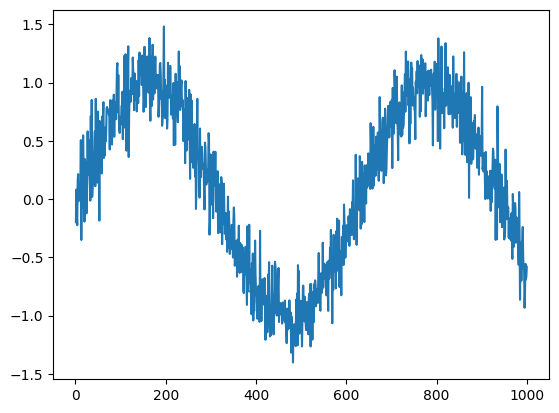

In [140]:
plt.plot(time, x)

In [141]:
tau=4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T-tau+i]
labels=x[tau:].reshape(-1,1)


batch_size=16
n_train=600

In [142]:
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential=nn.Sequential(
            nn.Linear(4, 10)
            ,nn.ReLU()
            ,nn.Linear(10, 1))
        self.sequential.apply(init_weights)
    def forward(self,x):
        return self.sequential(x)

In [143]:
class TimeDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data            # 数据路径或数据本身
        self.labels = labels         # 标签
        self.transform = transform  # 数据预处理（如transforms.Compose）

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

In [144]:
data=TimeDataset(features[:600], labels[:600])
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
loss=nn.MSELoss(reduction='none')

In [145]:
def train(model, train_iter, loss, epoch, lr):
    trainer=torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epoch):
        for x,y in train_iter:
            trainer.zero_grad()
            y_hat=model(x)
            l=loss(y_hat, y)
            l.sum().backward()
            trainer.step()
        
        loss_eval=0
        for x,y in train_iter:
            loss_eval+=loss(model(x), y).sum()
        
        print(f'epoch {epoch + 1}, '
              f'loss: {loss_eval})')
    

In [155]:
net=Net()

In [156]:
train(net,dataloader,loss,5,lr=0.01)

epoch 1, loss: 35.8764762878418)
epoch 2, loss: 31.03284454345703)
epoch 3, loss: 32.52228927612305)
epoch 4, loss: 30.084991455078125)
epoch 5, loss: 28.930330276489258)


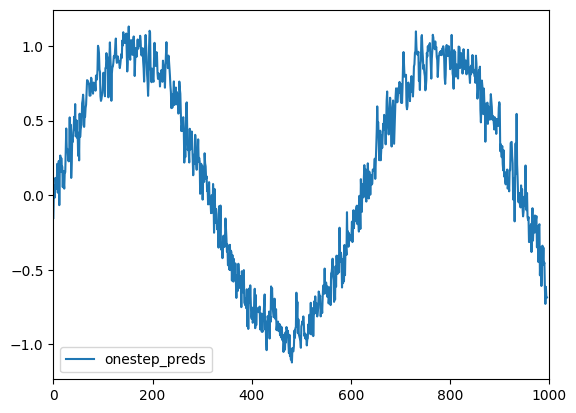

In [157]:
plt.plot(net(features).detach().numpy())
plt.legend(['onestep_preds'])
plt.xlim([0,1000])
plt.show()

In [164]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

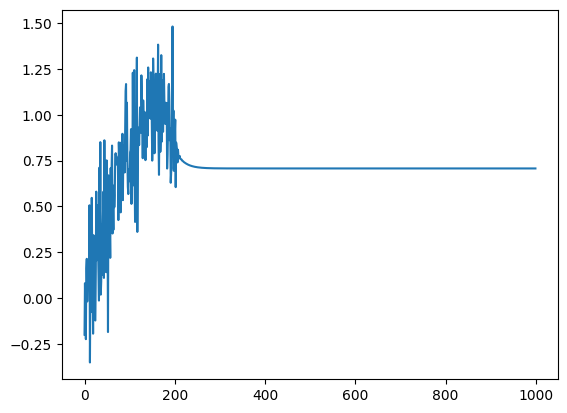

In [165]:
plt.plot(multistep_preds.detach().numpy())
##这个地方出错是正常的

In [176]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

In [179]:
features

tensor([[-0.1995,  0.0812, -0.1189,  ..., -0.0181, -0.0181, -0.0181],
        [ 0.0812, -0.1189, -0.2240,  ..., -0.0179, -0.0179, -0.0179],
        [-0.1189, -0.2240,  0.1625,  ..., -0.0176, -0.0177, -0.0177],
        ...,
        [-0.3506,  0.1034,  0.0487,  ..., -0.0181, -0.0181, -0.0181],
        [ 0.1034,  0.0487, -0.3450,  ...,  0.6863,  0.6875,  0.6886],
        [ 0.0487, -0.3450,  0.7957,  ...,  0.6974,  0.6980,  0.6985]],
       grad_fn=<CopySlices>)